<h1><center>EWPredict</center></h1>


The goal of this project is to utilize machine learning algorithms to catagorize seismic records based on information produced by [Empirical Wavelet Method](https://github.com/Leviyu/EQTime). 

Being able to automatically predict the quality (accept or reject) of seismic record combined with Empriical Wavelet Making mathod would allows us to build seismic dataset in a fast, systematical and consistant manner. And being able to do so, would allow us to establish first step towards a new era for seismology.

## Project Objective

We have gathered 50 processed earthquake event data from [Empirical Wavelet Method](https://github.com/Leviyu/EQTime). For each event, there are thousands of seismic stations recordings that is documented. Each seismic records is associated with comprehensive measurements that is related to its signal-to-noise ratio, waveform distortation, amplitude attenuation et al., as show below in Figure. 




Fig.jpg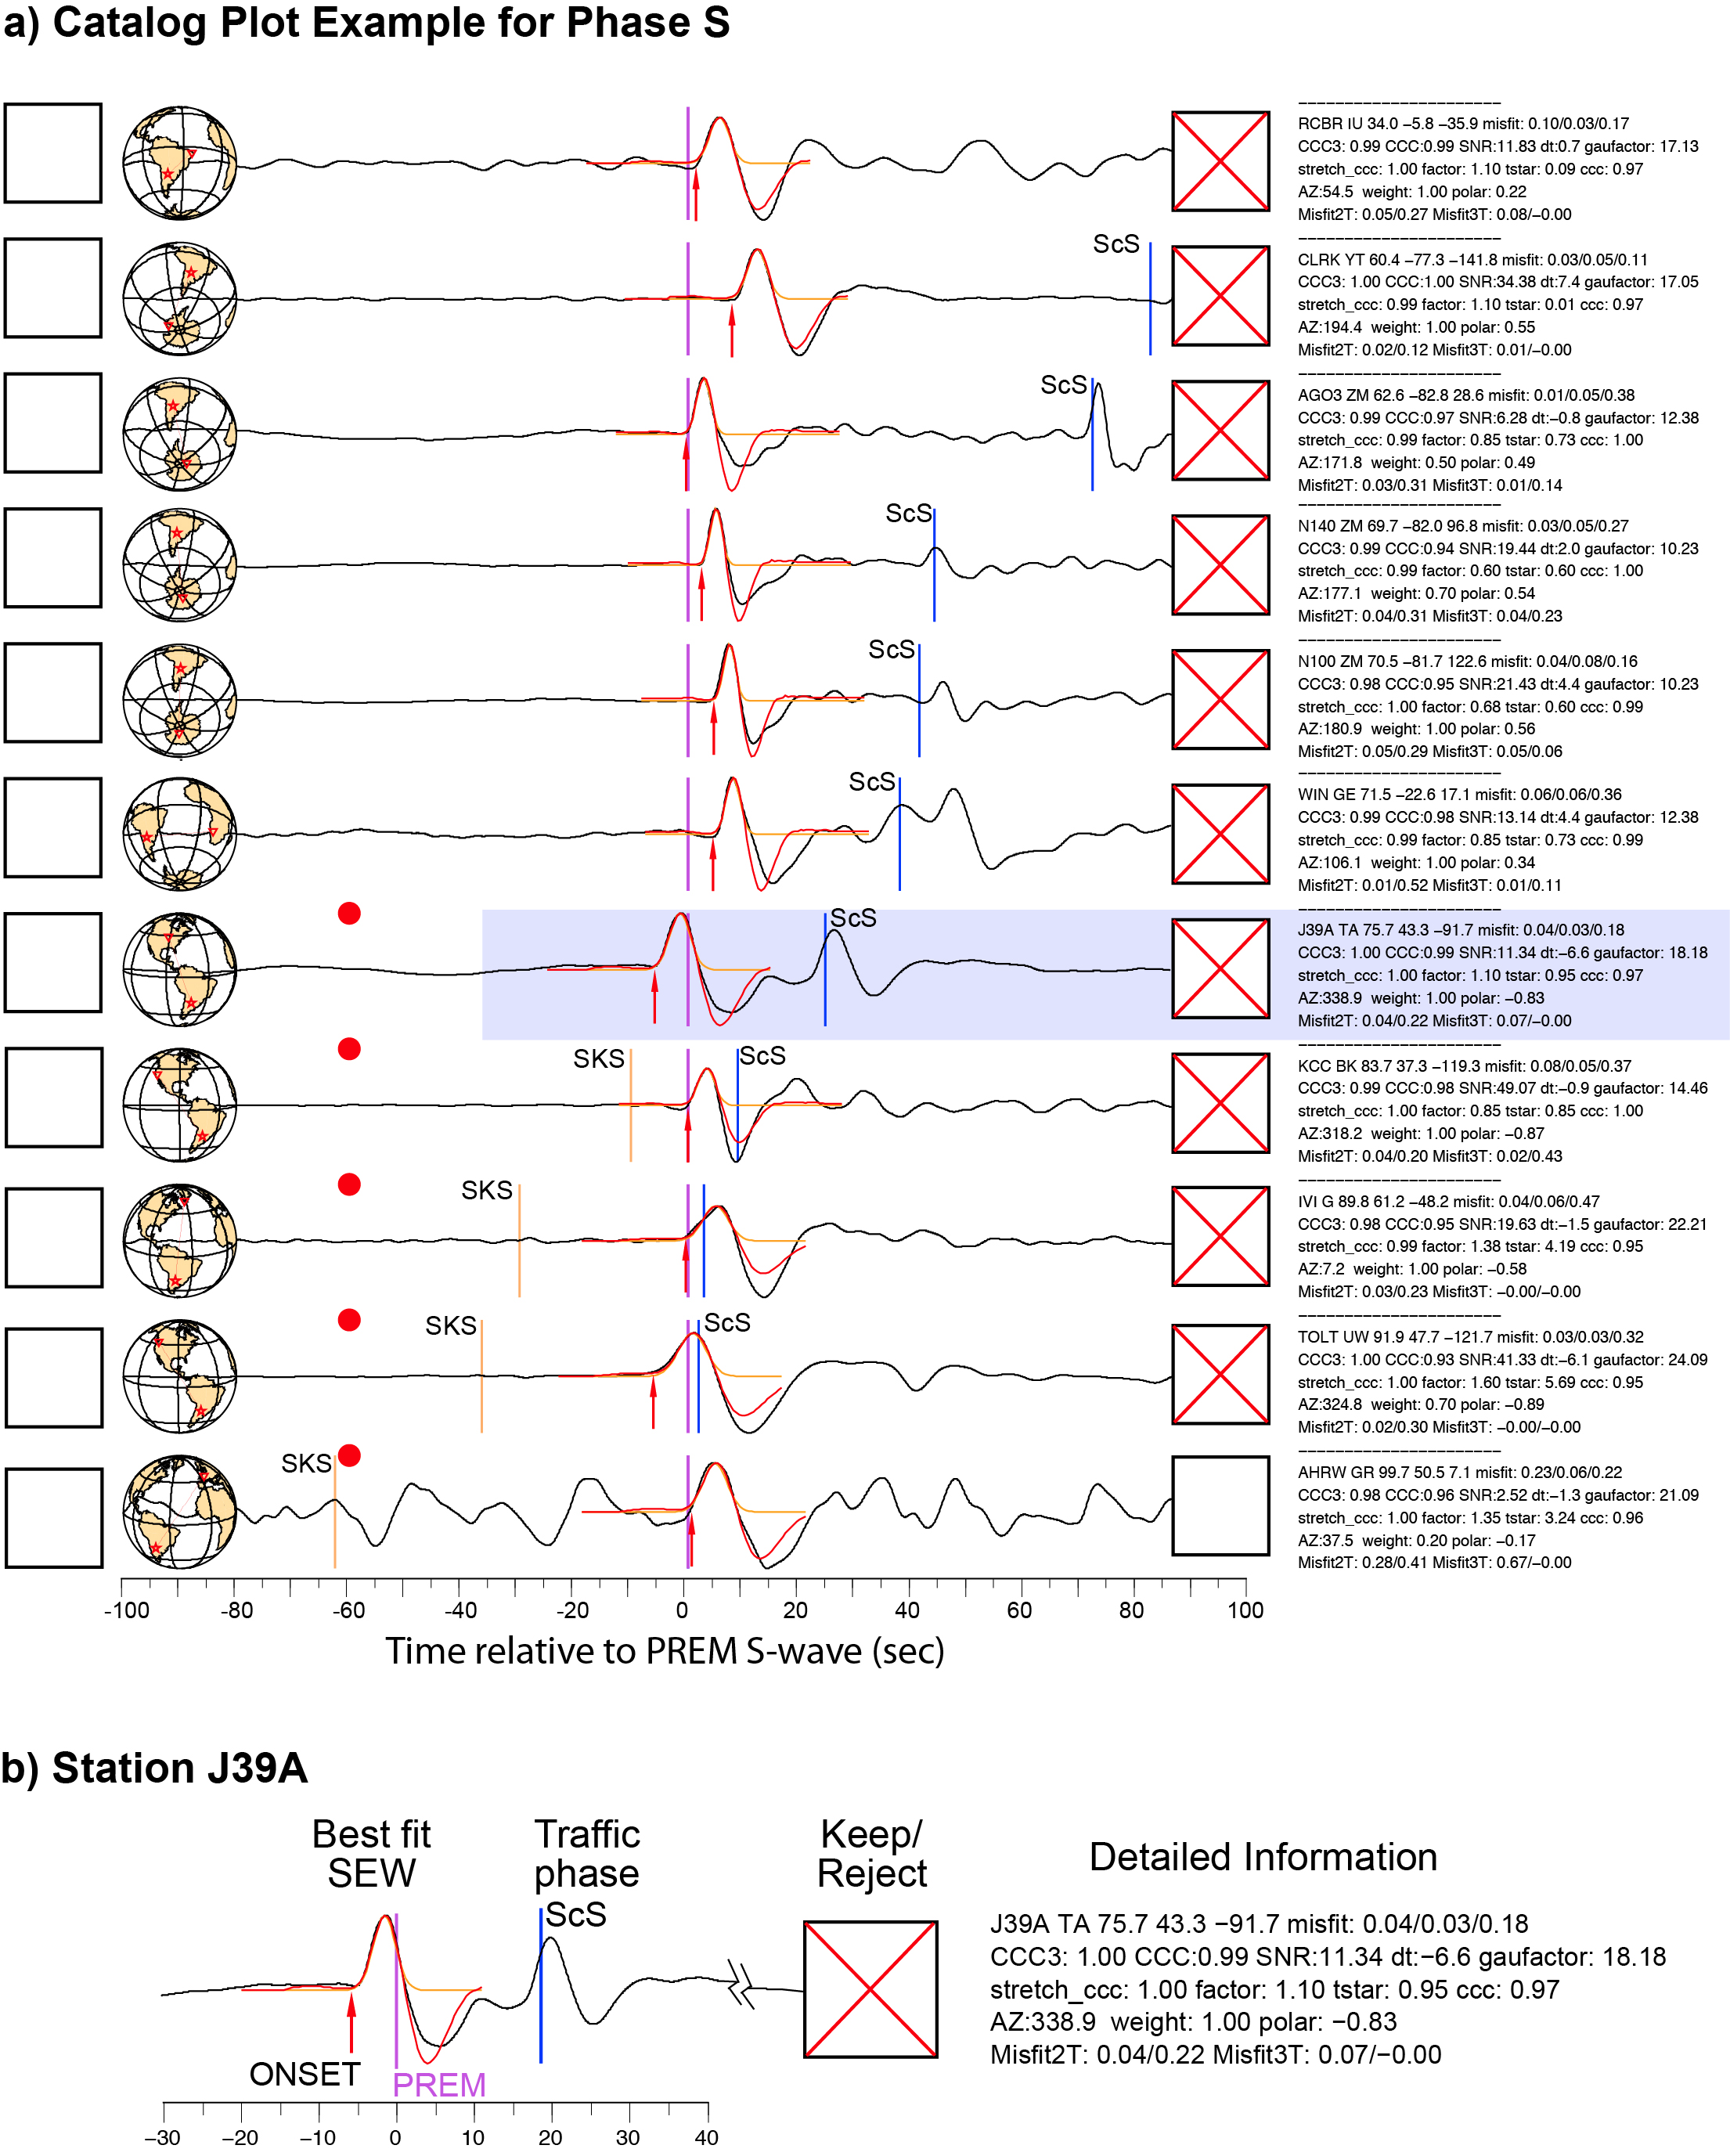

### Data Detail
The boxes on the right side is the algorithm that we implemented based on very simple rules to distinguish the signal from the background noise (in this example, the cross in the box means it is accepted and has high quality, otherwise it is rejected). Unfortunately, seismic data are intrinsicly complex and our simple algorithm does not perform at the level that we wanted. So the project is our efforts to train machine learning model to accurately classify our sesimic records into 'accept' and 'reject' catagory. 

To train the model, we have manually classified seismic data from about 50 earthquakes, which is about 170k data entries. And we use this data to train supervised learning model and test the performance.




Below is the workflow that is implemented in this project:


### Feature Exploration
1. Explorationary Data Analysis with Virtualization

    a. check feature variable distribution

    b. check missing data

    c. check outlier
    
    d. convert certain numerical feature into categorial
    
    e. convert certain label features into categorial
    
    f. check correlation between different features
    
    
2. Feature engineering

    Analysis the correlation logic between feature and target variable and design new features by combine, compare or convert origonal features
    
### Model Training

3. Use training data to train different classification models

    and also cross-compare the performance of different models

4. Ensembling

    which is to construct layer models to improve the performance of final predict model
 
    We used the following method in our ensembling models:

        * Boosting
        * Blending
        * Stacking

    
    
    
To make this project scaleable, we build pipeline that enable:
* Modularized feature transformations
* Automated grid search for hyperparameter space
* Automated ensemble selection


In [1]:
# Import Necessary Library

import sys
import pandas as pd 
import matplotlib as plt
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time

import warnings
warnings.filterwarnings("ignore")
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier
import time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Data

The data contains two parts, the first part is the raw seismic meta information produced my Empirical Wavelet Method.

The dataset we use here is constructed from 50 seismic events.

(Where does the 50 events come from?)


It contains all kind of features and also have pick information based on hardwired rules, which is not always reliable.

The second part is the binery quality label of each seismic meta record, which is manually labled and stored seperatedly as a file.

In [2]:
# Read in seismic meta info

header = pd.read_csv("./data/header",sep=" ")


data_file = "./data/eventinfo.EW.train.csv"
data = pd.read_csv(data_file,sep=r'\s+',names=header.columns)
print("----> Read in train events, dimension is {}".format(data.shape))
# read in binery quality label
picked_flag = "./data/picked_flag.csv"
keep = pd.read_csv(picked_flag,sep=' ')
print("----> Read in quality label, dimension is {}".format(keep.shape))

----> Read in train events, dimension is (645778, 54)
----> Read in quality label, dimension is (260571, 1)


In [3]:
keep.head()

,FLAG
0,199401101553_FURB_ScSScS_1
1,199401101553_FRMB_ScSScS_1
2,199401101553_PKD1_ScSScS_-1
3,199401101553_SAO_ScSScS_-1
4,199401101553_BKS_ScSScS_-1


In [4]:
# create EQ_NAME_STA_PHASE
data['EQ_NAME_STA_PHASE'] = data['EQ_NAME'].map(str) +"_"+ data['STA']+ "_"+ data['PHASE']+"_"+data['POLARFLAG'].map(str)
data['EQ_NAME_STA_PHASE'].head()
# pd.concat([data['EQ_NAME'],data['PHASE']])

0     199401101553_FURB_ScSScS_1
1     199401101553_CDCB_ScSScS_1
2     199401101553_ISA_ScSScS_-1
3     199401101553_SBC_ScSScS_-1
4    199401101553_PKD1_ScSScS_-1
Name: EQ_NAME_STA_PHASE, dtype: object

In [5]:
# data.head()
# keep.head()

In [6]:
keep['DECISION'] = 1
keep.columns=['EQ_NAME_STA_PHASE','DECISION']
keep.head()

,EQ_NAME_STA_PHASE,DECISION
0,199401101553_FURB_ScSScS_1,1
1,199401101553_FRMB_ScSScS_1,1
2,199401101553_PKD1_ScSScS_-1,1
3,199401101553_SAO_ScSScS_-1,1
4,199401101553_BKS_ScSScS_-1,1


In [7]:
data = data.merge(keep,on='EQ_NAME_STA_PHASE',how='left')

In [8]:
# data['DECISION'].head(20)
data['DECISION'].fillna(0,inplace=True)

In [9]:
# Define new PICK flag from dataframe based on whether the quality label
## Check pick rate amont all data
# 1 is accpeted
# 0 is rejected

pick_num = data.loc[data.DECISION==1].shape[0]
total_num = data.shape[0]
pick_rate = pick_num/total_num
print("Numberof_record pick {0:.0f} total {1:.0f} pick rate{2:.2f}".format(pick_num,total_num,pick_rate))



Numberof_record pick 94200 total 645778 pick rate0.15


[[531882  19696]
 [ 44338  49862]]
TP is  49862
FP is  44338
--------> Precision is 0.5293 recall is 0.7168 and F1 is 0.6090 accuracy is 0.9008


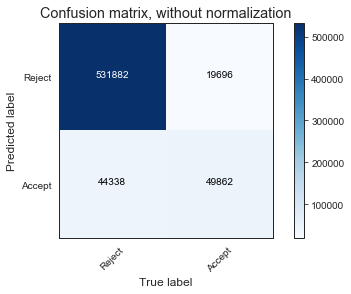

In [10]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    print(cm)
    TP = cm[1][1]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[0][0] 
    print("TP is ",TP)
    print("FP is ", FP)
    Accuracy = (TP + TN) /(TP + FN + FP + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * ( precision * recall ) / ( precision + recall)
    print("--------> Precision is {0:.4f} recall is {1:.4f} and F1 is {2:.4f} accuracy is {3:.4f}".format(precision,
                                                                         recall,
                                                                         F1,Accuracy))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

# make new columns show code decision
# data["CODE_DECISION"] = 0
data.loc[(data.QUALITY >=1),"CODE_DECISION"] = 1
data.loc[(data.QUALITY < 1),"CODE_DECISION"] = 0


# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data.DECISION, data.CODE_DECISION)
np.set_printoptions(precision=2)

class_names = ['Reject', 'Accept']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


## Step1: Define the Problem

Background: 
Though automated processing code I developed during my Ph.D. [EQTime](https://github.com/Leviyu/EQTime), I have collected a huge seismic dataset. The dataset consists of many scientific measurements as well as quality measurements. The nature of seismology is to identify confident signal from background noise. The dataset that I have gather contains records that can be used for seismic study and those that are too noise/or have other issues and thus should be rejected.

Each record should be classified into two catagories:
* Reject
* Accept

For the dataset that I have gathered, we have manually went through the dataset and make decision whether to accept or reject each record. Our goal is to see if we can use machine learning algorithm to learn our decision choices.

This is a classic binary classification problem in machine learning.

In [11]:
# data.ONE_PERIOD.hist(bins=100)

## Data Exploration

In [12]:
data.head()
# data.SNR_PEAK.unique()

,STA,NET,DIST,AZ,BAZ,STA_LAT,STA_LON,EQ_LAT,EQ_LON,EQ_DEP,...,BAK2T,BAK3T,SNR_TROUGH,SNR_PEAK,SNR_SMALL,TRAFFIC_IN_NOISE,ONE_PERIOD,EQ_NAME_STA_PHASE,DECISION,CODE_DECISION
0,FURB,BL,23.276,111.427,284.603,-20.678,-46.278,-13.335,-69.41,604.9,...,0.12,-0.00,0.0,0.0,0,0,29.2,199401101553_FURB_ScSScS_1,1.0,1.0
1,CDCB,BL,24.597,109.534,282.331,-20.236,-44.718,-13.335,-69.41,604.9,...,-0.00,-0.00,0.0,0.0,0,0,36.8,199401101553_CDCB_ScSScS_1,0.0,1.0
2,ISA,CI,67.274,318.169,127.134,35.663,-118.474,-13.335,-69.41,604.9,...,0.44,-0.00,0.0,0.0,0,0,28.6,199401101553_ISA_ScSScS_-1,0.0,1.0
3,SBC,CI,67.368,316.450,125.762,34.441,-119.715,-13.335,-69.41,604.9,...,0.52,0.26,0.0,0.0,0,0,26.0,199401101553_SBC_ScSScS_-1,0.0,1.0
4,PKD1,BK,68.686,317.349,125.690,35.889,-120.426,-13.335,-69.41,604.9,...,0.20,0.36,0.0,0.0,0,0,25.6,199401101553_PKD1_ScSScS_-1,1.0,1.0


In [13]:
# Check for null value and clean
data.NET.fillna("NNN",inplace=True)
data = data.dropna()
data.isnull().sum()

STA                  0
NET                  0
DIST                 0
AZ                   0
BAZ                  0
STA_LAT              0
STA_LON              0
EQ_LAT               0
EQ_LON               0
EQ_DEP               0
EQ_MAG               0
EQ_NAME              0
POLARFLAG            0
QUALITY              0
PREM                 0
AMP                  0
CCC1                 0
SNRAVE               0
DT                   0
PHASE                0
STRETCHC             0
STRETCHF             0
MISFITSIG            0
COMP                 0
TAG1                 0
TAG2                 0
TAG3                 0
TAG4                 0
TAG5                 0
WEIGHT               0
TAG6                 0
TAG7                 0
ONSET                0
ENDSET               0
TSTARF               0
TSTARC               0
CCC2                 0
MISFITPRE            0
MISFITBAK            0
GRECORD              0
GSEW                 0
GMISFIT              0
POLARITY             0
POLAR_RIGHT

In [14]:
print("size of data is {}".format(data.shape))

size of data is (642993, 57)


In [15]:
# drop columns that is obviously not correlated with the quality of the record
drop_list = [
"STA",
'PREM',
'AMP',
'TAG1',
'TAG2',
'TAG3',
'TAG4',
'TAG5',
'TAG6',
'TAG7',
'ONSET',
'ENDSET',
'PRE3T',
'BAK3T',
"EQ_NAME_STA_PHASE",
"AZ",
'COMP'
]

for col in drop_list:
    if col in data.columns:
        data = data.drop(col,axis=1)

# drop columns that has only one value
for col in data.columns:
    uniquenum = data[col].unique().shape[0]
    if uniquenum == 1:
        data = data.drop(col,axis=1)
        

In [16]:
# new data shape 
print("New shape is: {}".format(data.shape))

New shape is: (642993, 37)


In [17]:
# Backup original data
data_raw = data.copy()

In [18]:
# Classify different features into numerical and categorial features
numerical_feature = [
'DIST', 'CCC1', 'SNRAVE', 'DT',
'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF',
'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT',
'POLARITY', 'PRE2T', 'BAK2T',
'ONE_PERIOD',
'EQ_DEP','EQ_MAG',
'STA_LAT','STA_LON','BAZ','EQ_LON','EQ_LAT',
'GSEW','SNR_PEAK'
                    ]
categorial_feature = [
'NET', 
'POLARFLAG', 
'QUALITY',
'POLAR_RIGHT',
'TRAFFIC_IN_NOISE',
'TRAFFIC',
'CODE_DECISION'
    ]
dummy_feature = [
    'PHASE'
]


print("total feature num is {0} numerical feature num is {1} categorial feature num is {2}".format(
data.shape[1],len(numerical_feature),len(categorial_feature)))

feat_resi = [x for x in data.columns if x not in numerical_feature if x not in categorial_feature
            if x not in dummy_feature]

# all_feat = [x for x in numerical_feature or x in dummy_feature or x in categorial_feature]
all_feat = numerical_feature + dummy_feature + categorial_feature
# all_feat
for col in all_feat:
    if col not in data.columns:
        all_feat.remove(col)
        if col in numerical_feature:
            numerical_feature.remove(col)
        if col in categorial_feature:
            categorial_feature.remove(col)

print(all_feat,len(all_feat))
print(feat_resi)

total feature num is 37 numerical feature num is 28 categorial feature num is 7
['DIST', 'CCC1', 'SNRAVE', 'DT', 'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF', 'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT', 'POLARITY', 'PRE2T', 'BAK2T', 'ONE_PERIOD', 'EQ_DEP', 'EQ_MAG', 'STA_LAT', 'STA_LON', 'BAZ', 'EQ_LON', 'EQ_LAT', 'GSEW', 'PHASE', 'NET', 'POLARFLAG', 'QUALITY', 'POLAR_RIGHT', 'TRAFFIC_IN_NOISE', 'TRAFFIC', 'CODE_DECISION'] 35
['EQ_NAME', 'DECISION']


In [19]:
# For categorial features, we directly label encode them

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',categorical_features=[0])
label = LabelEncoder()    

# for categorial feature, we use label endocing
for feature in categorial_feature:
    print("--> Work on ", feature)
    label.fit(data[feature])
    # save encoder
    np.save(feature+'.encoder',label.classes_)
#     print(label)
    data[feature] = label.transform(data[feature])

--> Work on  NET
--> Work on  POLARFLAG
--> Work on  QUALITY
--> Work on  POLAR_RIGHT
--> Work on  TRAFFIC_IN_NOISE
--> Work on  TRAFFIC
--> Work on  CODE_DECISION


In [20]:

    
# For dummy variable we use onehotencoding
new_dummy = []
for feature in dummy_feature:
    print("--> work on dummy feature", feature)
    ff = pd.get_dummies(data[feature])
    for f in ff.columns:
        new_dummy.append(f)
    data = pd.concat([data,ff],axis=1)
    data.drop(feature,inplace=True,axis=1)
      
print("new dummy features are ", new_dummy)


--> work on dummy feature PHASE
new dummy features are  ['S', 'SS', 'SSS', 'ScS', 'ScSScS', 'Sdiff']


In [21]:
all_feat.remove('PHASE')
for col in new_dummy:
    all_feat.append(col)

In [22]:
data.head()

,NET,DIST,BAZ,STA_LAT,STA_LON,EQ_LAT,EQ_LON,EQ_DEP,EQ_MAG,EQ_NAME,...,TRAFFIC_IN_NOISE,ONE_PERIOD,DECISION,CODE_DECISION,S,SS,SSS,ScS,ScSScS,Sdiff
0,34,23.276,284.603,-20.678,-46.278,-13.335,-69.41,604.9,6.9,199401101553,...,0,29.2,1.0,1,0,0,0,0,1,0
1,34,24.597,282.331,-20.236,-44.718,-13.335,-69.41,604.9,6.9,199401101553,...,0,36.8,0.0,1,0,0,0,0,1,0
2,46,67.274,127.134,35.663,-118.474,-13.335,-69.41,604.9,6.9,199401101553,...,0,28.6,0.0,1,0,0,0,0,1,0
3,46,67.368,125.762,34.441,-119.715,-13.335,-69.41,604.9,6.9,199401101553,...,0,26.0,0.0,1,0,0,0,0,1,0
4,33,68.686,125.690,35.889,-120.426,-13.335,-69.41,604.9,6.9,199401101553,...,0,25.6,1.0,1,0,0,0,0,1,0


## Data Exploration


### Virtualize the correlation of each feature


--> work on  NET
--> work on  POLARFLAG
--> work on  QUALITY
--> work on  POLAR_RIGHT
--> work on  TRAFFIC_IN_NOISE
--> work on  TRAFFIC
--> work on  CODE_DECISION


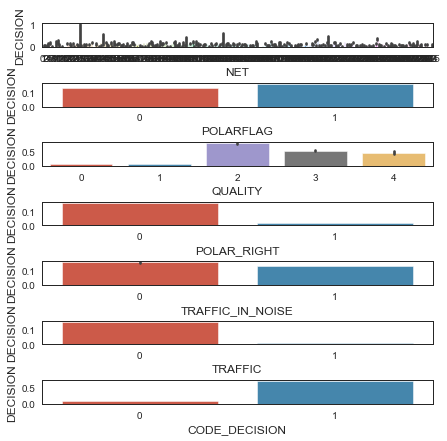

In [23]:
my_feature = categorial_feature
fignum = len(my_feature)

fig, axes = plt.subplots(fignum,1,figsize=(len(my_feature),fignum))
plt.subplots_adjust(hspace=1.5)

for index,feature in enumerate(my_feature):
    print("--> work on ",feature)
    sns.barplot(x=feature,y='DECISION',data=data,ax=axes[index])

plt.show()

### Virtualize the correlation of dummy feature

--> work on  S
--> work on  SS
--> work on  SSS
--> work on  ScS
--> work on  ScSScS
--> work on  Sdiff


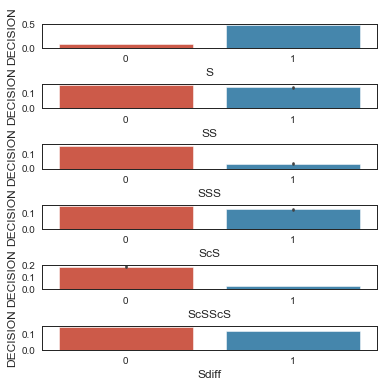

In [24]:

my_feature = new_dummy
fignum = len(my_feature)
fig, axes = plt.subplots(fignum,1,figsize=(len(my_feature),fignum))
plt.subplots_adjust(hspace=1.5)
for index,feature in enumerate(my_feature):
    print("--> work on ",feature)
    sns.barplot(x=feature,y='DECISION',data=data,ax=axes[index])
plt.show()

### Truncate extreme values in the dataset

In [25]:
# Remove outlier
feat = 'SNRAVE'
value = 30
data.loc[data[feat]>value,feat] = value

feat = 'MISFITSIG'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'MISFITPRE'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'MISFITBAK'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'GMISFIT'
value = 50
data.loc[data[feat]>value,feat] = value


feat = 'PRE2T'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'BAK2T'
value = 10
data.loc[data[feat]>value,feat] = value



### For numerial features, we use ked plot to plot the correlation


----> Work on feature  DIST
----> Work on feature  CCC1
----> Work on feature  SNRAVE
----> Work on feature  DT
----> Work on feature  STRETCHC
----> Work on feature  STRETCHF
----> Work on feature  MISFITSIG
----> Work on feature  WEIGHT
----> Work on feature  TSTARF
----> Work on feature  TSTARC
----> Work on feature  CCC2
----> Work on feature  MISFITPRE
----> Work on feature  MISFITBAK
----> Work on feature  GRECORD
----> Work on feature  GMISFIT
----> Work on feature  POLARITY
----> Work on feature  PRE2T
----> Work on feature  BAK2T
----> Work on feature  ONE_PERIOD
----> Work on feature  EQ_DEP
----> Work on feature  EQ_MAG
----> Work on feature  STA_LAT
----> Work on feature  STA_LON
----> Work on feature  BAZ
----> Work on feature  EQ_LON
----> Work on feature  EQ_LAT
----> Work on feature  GSEW


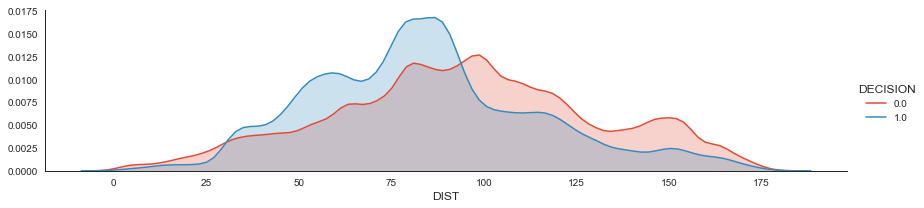

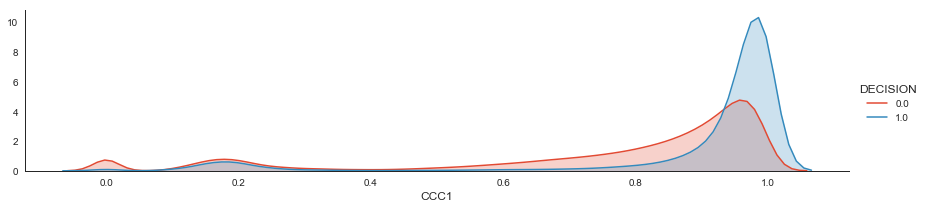

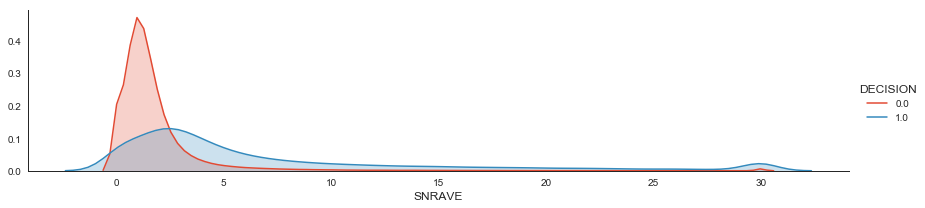

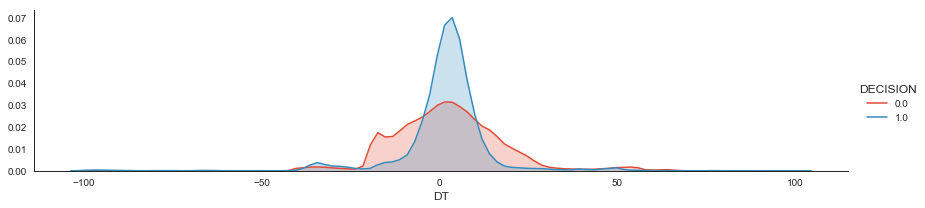

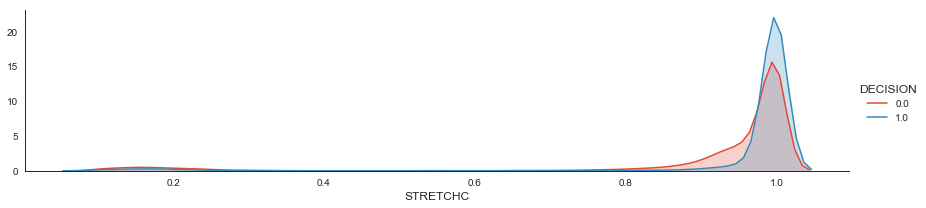

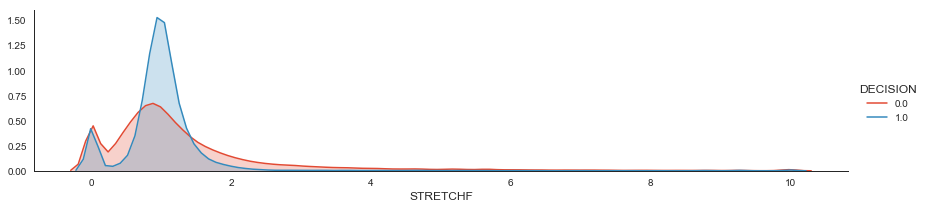

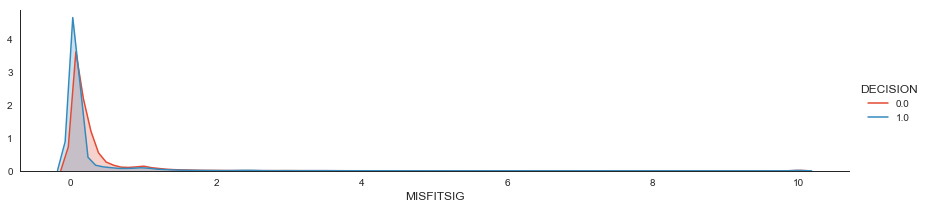

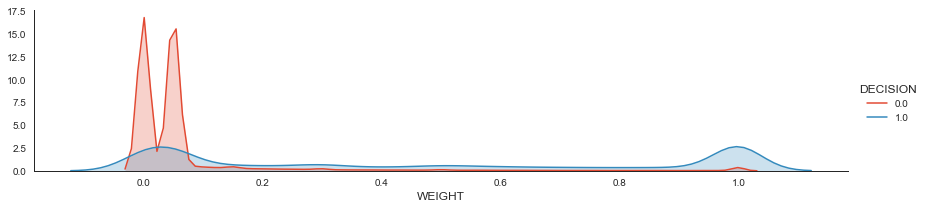

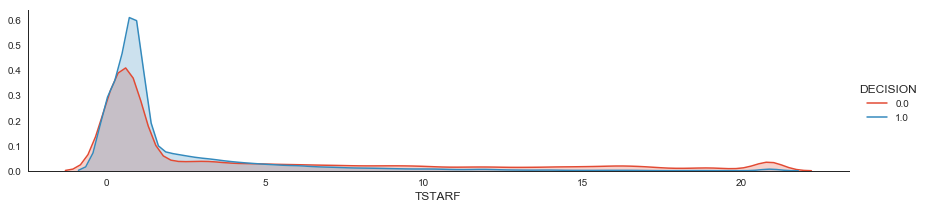

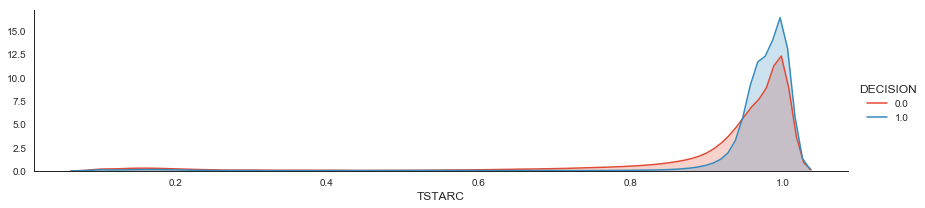

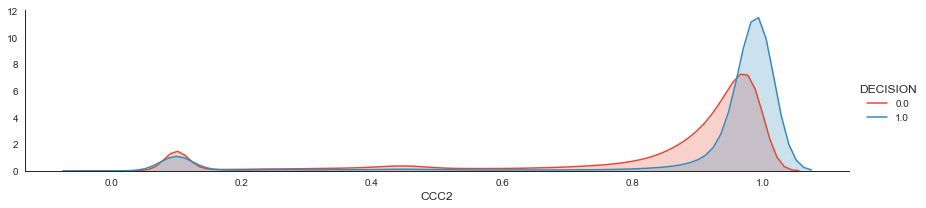

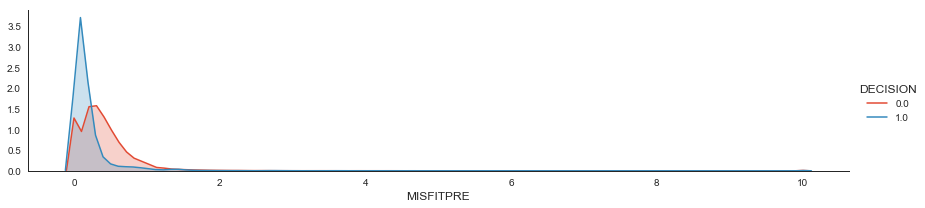

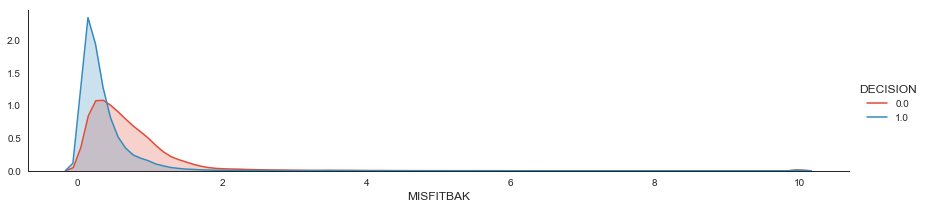

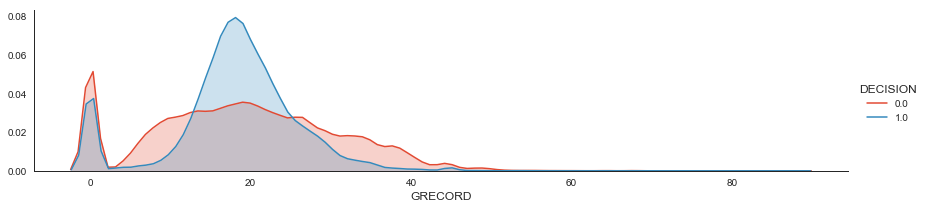

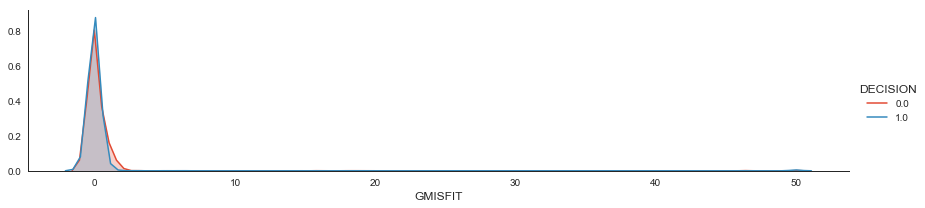

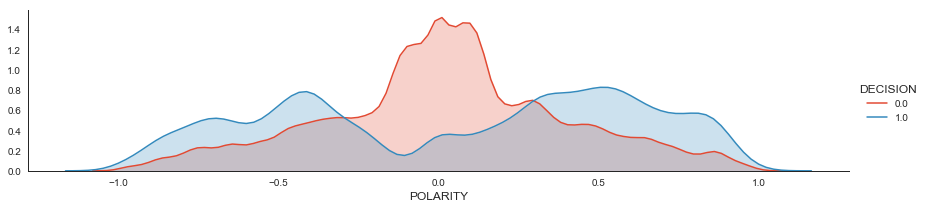

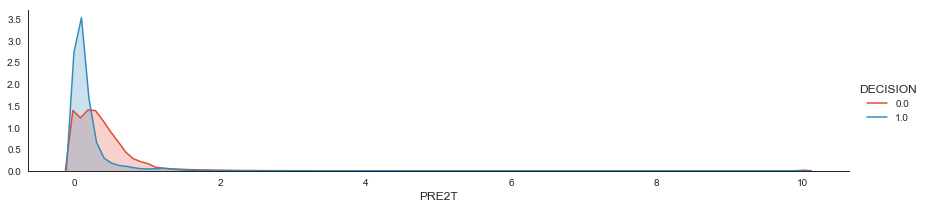

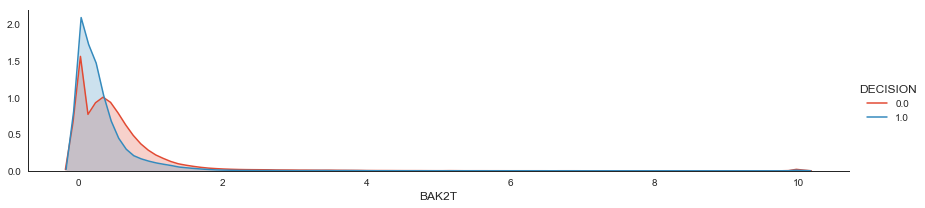

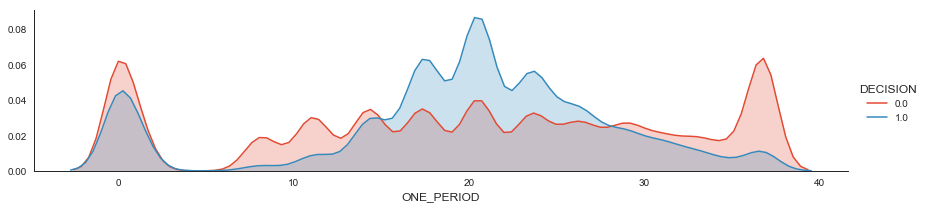

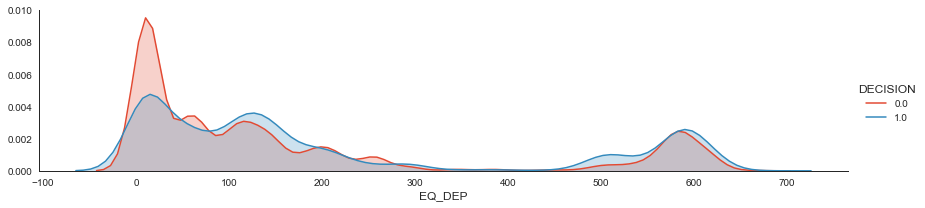

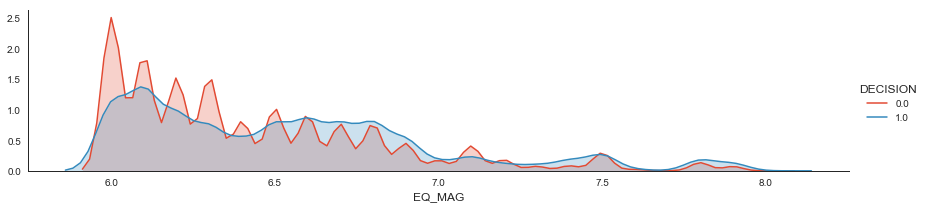

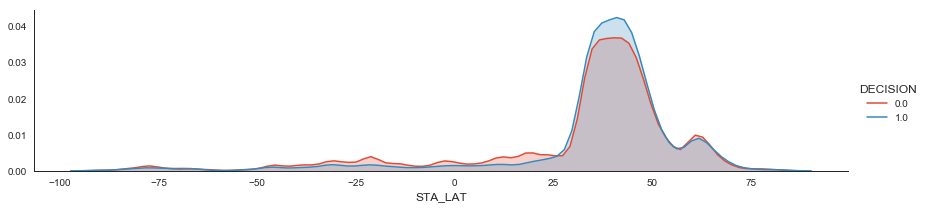

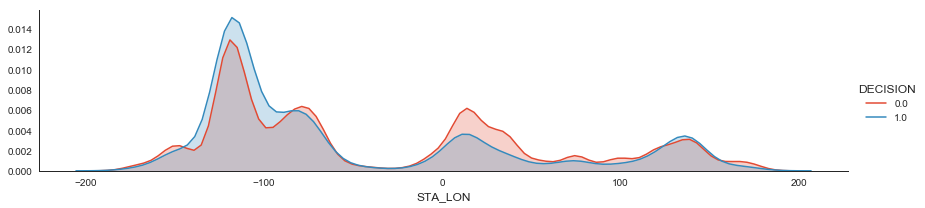

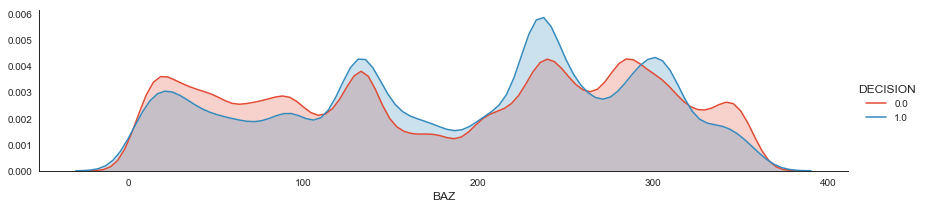

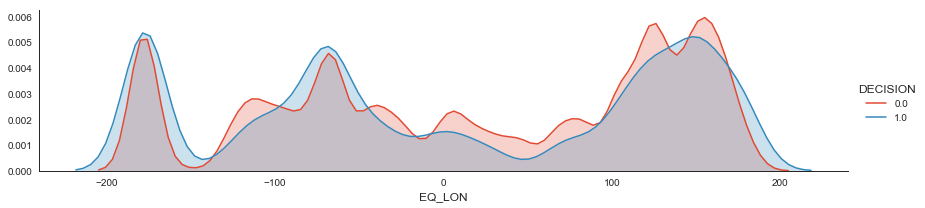

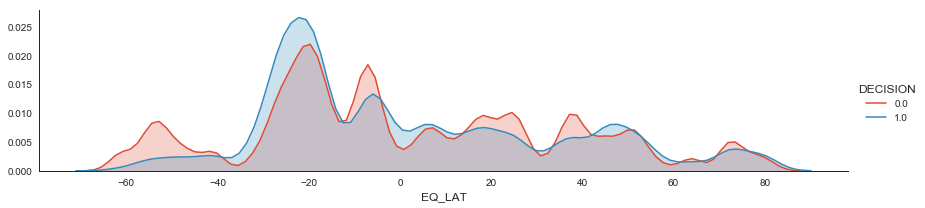

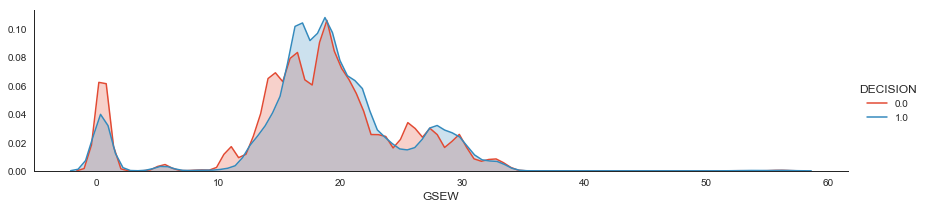

In [26]:
for feature in numerical_feature:
    print('----> Work on feature ', feature)
    a = sns.FacetGrid(data,hue="DECISION",aspect=4)
    a.map(sns.kdeplot,feature,shade=True)
    a.add_legend()

### Use StandardScaler to transform numerical features to unit distribution

This transformation would make our numerical features to have 0 mean and unit standard deviation.


In [107]:
# scaler = preprocessing.StandardScaler()

# scaler.fit(data[numerical_feature])
# np.save('scaler.encoder',scaler.classes_)
# data[numerical_feature] = scaler.transform(data[numerical_feature])


### Get Pearson Correlation of Features

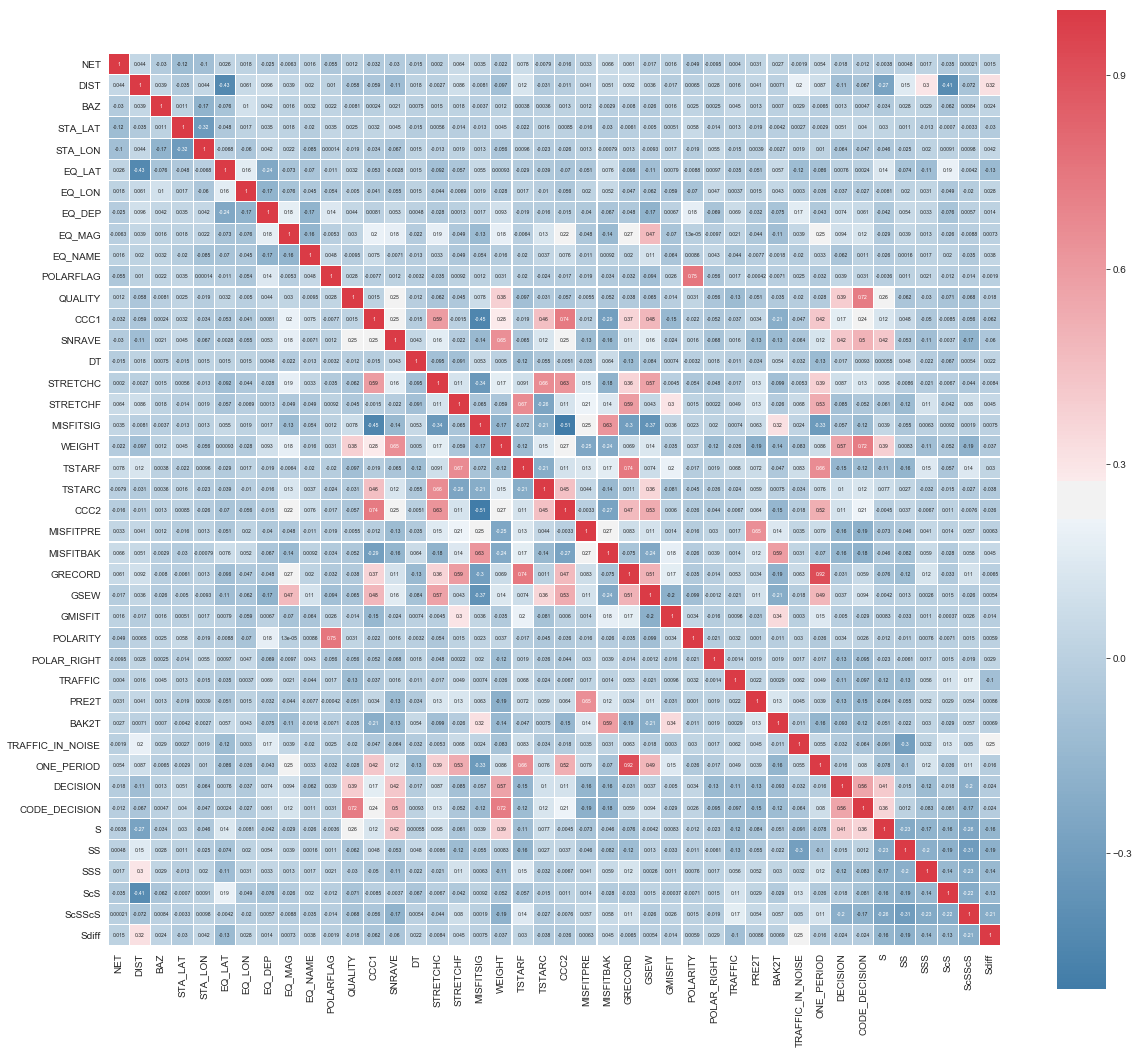

In [27]:

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(20, 20))
    colormap = sns.diverging_palette(240, 10, n=20, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':5 }
    )
# plt.title("Pearson Correlation of Features",y=1.05,size=15)
correlation_heatmap(data)

### Divide the dataset into dev and test 

* Dev set is used to train and cross-validate 

* Test set is to test final model


In [36]:
data['EQ_NAME'] = data['EQ_NAME'].astype(str)
data['YEAR'] = data['EQ_NAME'].str.slice(0,4).astype(int)
# print(data['YEAR'])
data2 = data.loc[data.YEAR>2006]
data2['EQ_NAME'] = data2['EQ_NAME'].astype(int)
data2.shape
dev_EQ_label = label.fit_transform(data2.EQ_NAME)    
# dev_EQ_label
data2['EQ_LABEL'] = dev_EQ_label

In [37]:
# exclude event list 
exclude_event_list = [
    '201408030830',
    '201407270128',
    '201404110707',
    '201208301343',
    '201207031036',
    '201205242247',
    '200908200635',
    '200906062033',
    '200812081839',
    '200807150326',
    '200804140945',
    '200802011210',
    '200712251404',
    '200712150803',
    '200712090728',
    '200711190052',
    '200709281338',
    '200709250516',
    '200708261237',
    '200708041424',
    '200609170934',
    '200609090413',
    '200608242150',
    '200608111430',
    '200606270259',
    '200606020731',
    '200605191444',
    '200603241227',
    '200603070628',
]
exclude_event_list = [int(x) for x in exclude_event_list]
# print(exclude_event_list)

data2_filter_index = data2['EQ_NAME'].apply(lambda x:x not in exclude_event_list)
# data2_filter_index

In [38]:
data2 = data2.loc[data2_filter_index]
data2.shape

(324570, 44)

In [39]:
test_EQ_label = np.random.randint(0,300,10)
# print(test_EQ_label)
x_dev_idx = data2['EQ_LABEL'].apply(lambda x: x not in test_EQ_label)
x_dev = data2.loc[x_dev_idx][all_feat]
y_dev = data2.loc[x_dev_idx]['DECISION']

x_dev_label = data2.loc[x_dev_idx]['EQ_LABEL']

x_test_idx = data2['EQ_LABEL'].apply(lambda x: x in test_EQ_label)
x_test = data2.loc[x_test_idx][all_feat]
y_test = data2.loc[x_test_idx]['DECISION']


print(x_dev.shape,x_test.shape)

(317226, 40) (7344, 40)


In [40]:
from sklearn.model_selection import cross_val_predict

## Build a class to implement model training and prediction


In [41]:
class MetaClassfier():
    def __init__(self,x_dev,y_dev,x_test,y_test,x_dev_label):
        print("---> Creating my own Meta Classifier")
        
        max_dev = 10000000
        
        self.x_dev = x_dev.head(max_dev)
        self.x_test = x_test
        self.y_dev = y_dev.head(max_dev)
        self.y_test = y_test
        self.x_dev_label = x_dev_label[:max_dev]
#         self.x_new = x_new
    
    
    def run(self):
        '''
        Workflow function for model training and prediciton
        '''
     
        # 1. Define models that we want to use
        self.define_models()
        
        # 2. train and cross-validate the model that we have selected
        # use metrics to evaluate the models performance
        self.train_cv_models()
        
        # 3. Use different models to predict with test dataset
#         self.train_predict()
        
        # 4. Ensemble the models and use ensembled models to calcualte
        # performance metrics
        
        
        # 5. Output prediction results and performance
        
        print(self.MLA)
        
    def define_models(self):
        '''
        Select which models to use
        '''
        self.columns = ['ModelName','CV_precision','CV_recall',
                       'precision','recall','CV_AUC','AUC']
        self.MLA = pd.DataFrame(columns=self.columns)
        self.n_jobs = -1
        self.base_models = {
#             "Dtree":DecisionTreeClassifier(),
            "RandomForest":RandomForestClassifier(n_jobs=self.n_jobs,n_estimators=50),
#             "GaussianNaiveBayesian":GaussianNB()
        }
        base_model_zip = []
        for k,v in self.base_models.items():
            base_model_zip.append((k,v))
        
        self.ensemble_models = {
#             'lgb':lgb(learning_rate=0.003,objective='binary',metric='binary_logloss')
#             'EnRandomForest':BaggingClassifier(RandomForestClassifier(),max_samples=0.6,n_jobs=self.n_jobs,bootstrap=True),
#             'AdaBoostDtree':AdaBoostClassifier(DecisionTreeClassifier()),
#             'AdaBoostRforest':AdaBoostClassifier(RandomForestClassifier(),n_estimators=100),
#             'GradientBoost':GradientBoostingClassifier(n_estimators=100,max_depth=1),
#             'VotingHard':VotingClassifier(estimators=base_model_zip,voting='hard'),
#             'VotingSoft':VotingClassifier(estimators=base_model_zip,voting='soft'),
            
        }
        
        self.models = { **self.base_models, **self.ensemble_models}
#         self.models = self.ensemble_models
        self.pred = pd.DataFrame(columns=self.MLA['ModelName'])
        self.pred_new = pd.DataFrame(columns=self.MLA['ModelName'])
    
        
        index = 0
        for model_name,model in self.models.items():
            self.MLA.loc[index,"ModelName"] = model_name
            index += 1
        
        
        
    def train_cv_models(self):
        '''
        Train and CV each model with KFold method
        '''
        nfolds = 5
        # train and cv split
        index = 0
        for model_name,model in self.models.items():
            print("---> Working on CV for %s" % model_name)
            start_time = time.time()
            
            
            
            cv = StratifiedKFold(n_splits = nfolds, shuffle=True, random_state=2016)
            oof = np.zeros(self.x_dev.shape[0])
            pred_test = np.zeros(self.x_test.shape[0])
            
            # for CV strategy we use k-1 event to train and 1 event to test, 
            # we do this for 10times
#             cv_meta = []
#             df_event = pd.DataFrame(self.x_dev_label.values,columns=['eq_flag'])
            
# #             print("---> df_event is ",df_event)
# #             print(self.x_dev_label)
#             for test_event in df_event.eq_flag.unique():
# #                 test_event = np.random.choice(self.x_dev_label,replace=False)
# #                 print("test evnet flag is ", test_event)
#                 train_event = [x for x in self.x_dev_label if x not in [test_event]]
                
#                 test_idx = df_event.loc[df_event.eq_flag == test_event ].index
#                 train_idx = df_event.loc[df_event.eq_flag != test_event].index
#                 cv_meta.append((train_idx,test_idx))
# #                 print(test_idx)
# #                 print(test_event)
            
#             print(cv_meta)
            for fold , ( trn_idx,test_idx) in enumerate(cv.split(x_dev,self.x_dev_label)):
#             for fold , ( trn_idx,test_idx) in enumerate(cv_meta):
                print("--> working on fold {0} train num {1} test num {2} ".format(fold,len(trn_idx),len(test_idx)))
                trn_data = self.x_dev.iloc[trn_idx]
                trn_label = self.y_dev.iloc[trn_idx]
                
                test_data = self.x_dev.iloc[test_idx]
                test_label = self.y_dev.iloc[test_idx]
                model.fit( test_data,test_label)
                oof[test_idx] = model.predict(test_data)
#                 print(model.predict(self.x_test)/len(cv_meta))
                pred_test += np.array(model.predict(self.x_test)) / nfolds
#                 print(pred_test)
            
            
            precision, recall,fbeta,support = precision_recall_fscore_support(self.y_dev,oof,average='binary')
            cv_auc = roc_auc_score(self.y_dev,oof)
            self.MLA.loc[index,'CV_AUC'] = cv_auc
            self.MLA.loc[index,'CV_precision'] = precision
            self.MLA.loc[index,'CV_recall'] = recall
            
            ### for test set
            pred_test_int = [ int(x > 0.5) for x in pred_test]
            print(set(pred_test_int))
            precision, recall,fbeta,support = precision_recall_fscore_support(self.y_test,pred_test_int,average='binary')
            cv_auc = roc_auc_score(self.y_test,pred_test_int)
            self.MLA.loc[index,'AUC'] = cv_auc
            self.MLA.loc[index,'precision'] = precision
            self.MLA.loc[index,'recall'] = recall
            
            index +=1
            
    def train_predict(self):
        '''
        Use each model to train and predict on test dataset 
        '''

        index = 0
        for model_name,model in self.models.items():
            print('----> Predicting for ',model_name)
            model.fit(self.x_dev,self.y_dev)
            pred = model.predict(self.x_test)
            self.pred[model_name] = pred
            auc = roc_auc_score(self.y_test.values,pred)
            print(pred)
            precision, recall,fbeta,support = precision_recall_fscore_support(self.y_test,pred,average='binary')
            self.MLA.loc[index,'precision'] = precision
            self.MLA.loc[index,'recall'] = recall
            self.MLA.loc[index,'f1_score'] = fbeta
            self.MLA.loc[index,'AUC'] = auc
        
        
            index += 1
    
    
    def make_new_prediction(self,x_new):
        for model_name,model in self.models.items():
            print('---> make new prediction on ', model_name)
            model.fit(self.x_dev,self.y_dev)
            pred_new = model.predict(x_new)
            return pred_new
    
    def ensemble_from_model_results(self):
        '''
        use predicted value from different models to ensemble new 
        prediction
        
        '''
        pass
        
    
meta = MetaClassfier(x_dev,y_dev,x_test,y_test,x_dev_label)
meta.run()
# meta.MLA.sort_values('f1_score',ascending=False)


---> Creating my own Meta Classifier
---> Working on CV for RandomForest
--> working on fold 0 train num 253767 test num 63459 
--> working on fold 1 train num 253772 test num 63454 
--> working on fold 2 train num 253778 test num 63448 
--> working on fold 3 train num 253786 test num 63440 
--> working on fold 4 train num 253801 test num 63425 
{0, 1}
      ModelName CV_precision CV_recall precision    recall    CV_AUC       AUC
0  RandomForest      0.99967  0.998306  0.429293  0.148213  0.999125  0.555872


In [267]:
# x_dev_label

In [112]:
# ddd = pd.DataFrame(columns=['true','pred'])
# ddd['true'] = y_new
# ddd['pred'] = pred_new
# print(ddd.loc[ (ddd.true == 1) & ( ddd.pred == 1) ].shape)
# print(ddd.loc[ (ddd.true == 1) & ( ddd.pred == 0) ].shape)
# print(ddd.loc[ (ddd.true == 0) & ( ddd.pred == 1) ].shape)
# print(ddd.loc[ (ddd.true == 0) & ( ddd.pred == 0) ].shape)
# print(ddd.shape)
# cnf_matrix = metrics.confusion_matrix(pred_new, y_new)
# np.set_printoptions(precision=2)
# class_names = ['Reject', 'Accept']
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

## We use LightGBM to train the model and evaluate the feature importance

In [113]:
import pickle
params = {
         'task':'train',
         'objective':'binary',
#          'objective':'multiclass',
#          "metric":'multi_logloss',
         "metric":'binary_logloss',
#         'metric': 'binary_error',
#          'num_class':2,
         'num_leaves': 31,
         'min_data_in_leaf': 25,
         'max_depth': 7,
         'learning_rate': 0.01,
#          'lambda_l1':0.13,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':8,
         "bagging_fraction": 0.9 ,
         "verbosity": -1,
         "random_state": 2333}

array([170,  98, 124, ..., 130, 100,  76])

In [251]:
all_feat

['DIST',
 'CCC1',
 'SNRAVE',
 'DT',
 'STRETCHC',
 'STRETCHF',
 'MISFITSIG',
 'WEIGHT',
 'TSTARF',
 'TSTARC',
 'CCC2',
 'MISFITPRE',
 'MISFITBAK',
 'GRECORD',
 'GMISFIT',
 'POLARITY',
 'PRE2T',
 'BAK2T',
 'EQ_DEP',
 'EQ_MAG',
 'STA_LAT',
 'STA_LON',
 'BAZ',
 'EQ_LON',
 'EQ_LAT',
 'GSEW',
 'NET',
 'POLARFLAG',
 'QUALITY',
 'POLAR_RIGHT',
 'TRAFFIC_IN_NOISE',
 'TRAFFIC',
 'CODE_DECISION',
 'S',
 'SS',
 'SSS',
 'ScS',
 'ScSScS',
 'Sdiff']

In [ ]:
to_drop = ['ONE_PERIOD','EQ_NAME']
for col in to_drop:
    if col in all_feat:
        all_feat.remove(col)
dev_EQ_label = data2['EQ_LABEL']
# print(len(x_dev),len(dev_EQ_label))

# We randomly keep 20% of the dataset as testing dataset
x_dev,x_test,y_dev,  y_test = model_selection.train_test_split(data2[all_feat],data2['DECISION'],test_size=0.2,random_state=5532)
dev_EQ_label = data2.loc[x_dev.index]['EQ_LABEL']
# print(x_dev.index)
print("Dev set shape is {}".format(x_dev.shape))
print("Test set shape is {}".format(x_test.shape))
    
feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=4500)
dev_pred = np.zeros(len(x_dev))
predictions = np.zeros(len(x_test))


for fold, (train_idx, val_idx) in enumerate(folds.split(x_dev,y_dev)):
    print("fold {}".format(fold))
    train_data = lgb.Dataset(x_dev.iloc[train_idx],label=y_dev.iloc[train_idx])
    val_data = lgb.Dataset(x_dev.iloc[val_idx],label=y_dev.iloc[val_idx])

    num_round = 7000 # Number of iterations 

    clf = lgb.train(params, train_data, num_round,
                    valid_sets=[val_data],verbose_eval=100,
                   categorical_feature=categorial_feature,
                   early_stopping_rounds=100)
    pickle.dump(clf,open('lightgbm_EW.'+str(fold)+'.pkl','wb'))

    dev_pred[val_idx] = clf.predict(x_dev.iloc[val_idx],num_iteration=clf.best_iteration)
    dev_pred_int = [int(x/0.5) for x in dev_pred[val_idx] ]
    
    auc = roc_auc_score(y_dev.iloc[val_idx].values,dev_pred[val_idx])
    
    precision, recall,fbeta,support = precision_recall_fscore_support(y_dev.iloc[val_idx],dev_pred_int,
                                                                             pos_label=1,
                                                                             average='binary')
    print("----> precision {0:.3f} recall {1:.3f} auc {2:.3f}".format( precision,recall, auc))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = x_dev.columns
    fold_importance_df['Importance']= clf.feature_importance()
    fold_importance_df['Fold'] = fold+1
    feature_importance_df = pd.concat([feature_importance_df,fold_importance_df],axis=0)
    predictions += clf.predict(x_test,num_iteration=clf.best_iteration) / folds.n_splits



Dev set shape is (259656, 39)
Test set shape is (64914, 39)
fold 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.222644
[200]	valid_0's binary_logloss: 0.176634
[300]	valid_0's binary_logloss: 0.155521
[400]	valid_0's binary_logloss: 0.143415
[500]	valid_0's binary_logloss: 0.135266
[600]	valid_0's binary_logloss: 0.129632
[700]	valid_0's binary_logloss: 0.125587
[800]	valid_0's binary_logloss: 0.122393
[900]	valid_0's binary_logloss: 0.120168
[1000]	valid_0's binary_logloss: 0.118139
[1100]	valid_0's binary_logloss: 0.116527
[1200]	valid_0's binary_logloss: 0.115267
[1300]	valid_0's binary_logloss: 0.11419
[1400]	valid_0's binary_logloss: 0.113307
[1500]	valid_0's binary_logloss: 0.11255
[1600]	valid_0's binary_logloss: 0.111917
[1700]	valid_0's binary_logloss: 0.111387
[1800]	valid_0's binary_logloss: 0.11086
[1900]	valid_0's binary_logloss: 0.110406
[2000]	valid_0's binary_logloss: 0.110015
[2100]	valid_0's binary_logloss: 0.109617


[4500]	valid_0's binary_logloss: 0.100811
[4600]	valid_0's binary_logloss: 0.100718
[4700]	valid_0's binary_logloss: 0.100587
[4800]	valid_0's binary_logloss: 0.10044
[4900]	valid_0's binary_logloss: 0.100317
[5000]	valid_0's binary_logloss: 0.100224
[5100]	valid_0's binary_logloss: 0.100174
[5200]	valid_0's binary_logloss: 0.100114
[5300]	valid_0's binary_logloss: 0.100026
[5400]	valid_0's binary_logloss: 0.0999414
[5500]	valid_0's binary_logloss: 0.0998515
[5600]	valid_0's binary_logloss: 0.0997847
[5700]	valid_0's binary_logloss: 0.0997113
[5800]	valid_0's binary_logloss: 0.0996311
[5900]	valid_0's binary_logloss: 0.0995415
[6000]	valid_0's binary_logloss: 0.0994848
[6100]	valid_0's binary_logloss: 0.0994385
[6200]	valid_0's binary_logloss: 0.0994019
[6300]	valid_0's binary_logloss: 0.0992989
[6400]	valid_0's binary_logloss: 0.0992251
[6500]	valid_0's binary_logloss: 0.0991689
[6600]	valid_0's binary_logloss: 0.0991072
[6700]	valid_0's binary_logloss: 0.0990889
[6800]	valid_0's bina

### Convert probability prediction into different classes

LightGBM precision 0.8474 recall 0.8648 f1 0.8560
LightGBM precision 0.8513 recall 0.8613 f1 0.8562
LightGBM precision 0.8547 recall 0.8577 f1 0.8562
LightGBM precision 0.8583 recall 0.8543 f1 0.8563
LightGBM precision 0.8617 recall 0.8510 f1 0.8563
LightGBM precision 0.8647 recall 0.8471 f1 0.8558
LightGBM precision 0.8682 recall 0.8436 f1 0.8558
LightGBM precision 0.8713 recall 0.8396 f1 0.8551
LightGBM precision 0.8739 recall 0.8352 f1 0.8541
LightGBM precision 0.8774 recall 0.8312 f1 0.8537
LightGBM precision 0.8800 recall 0.8267 f1 0.8525
LightGBM precision 0.8829 recall 0.8228 f1 0.8518
LightGBM precision 0.8861 recall 0.8196 f1 0.8515
LightGBM precision 0.8891 recall 0.8154 f1 0.8506
LightGBM precision 0.8923 recall 0.8108 f1 0.8496
LightGBM precision 0.8953 recall 0.8067 f1 0.8487
LightGBM precision 0.8982 recall 0.8028 f1 0.8478
LightGBM precision 0.9012 recall 0.7980 f1 0.8465
LightGBM precision 0.9040 recall 0.7935 f1 0.8452
LightGBM precision 0.9069 recall 0.7886 f1 0.8436


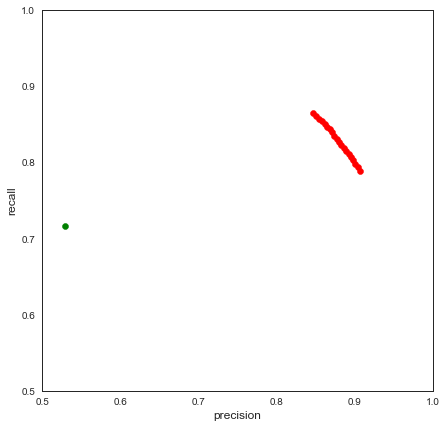

In [379]:
incs = np.linspace(0.4,0.6,20)
# print(incs)
plt.figure()
plt.xlim([0.5,1])
plt.ylim([0.5,1])
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(0.5293,0.7168,c='green')
for inc in incs:
    pred_ = [ x > inc for x in dev_pred]
#     pred_ = (dev_pred/inc).astype(int)
#     y_test_pred = (predictions/inc).astype(int)
    precision, recall,fbeta,support = precision_recall_fscore_support(y_dev,pred_,pos_label=1,average='binary')
    print("LightGBM precision {0:.4f} recall {1:.4f} f1 {2:.4f}".format(precision,recall,fbeta))
    plt.scatter(precision,recall,c='red')
plt.show()
# # Compute confusion matrix
# cnf_matrix = metrics.confusion_matrix(y_test_pred, y_test)
# np.set_printoptions(precision=2)
# class_names = ['Reject', 'Accept']
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')


In [ ]:
# # y_test_pred 
# # y_test
# ddd = pd.DataFrame(columns=['true','pred'])
# ddd.true = y_test
# ddd.pred = y_test_pred

# total = ddd.shape[0]
# # total
# print(ddd.loc[ (ddd.true == 1) & ( ddd.pred == 1) ].shape)
# print(ddd.loc[ (ddd.true == 1) & ( ddd.pred == 0) ].shape)
# print(ddd.loc[ (ddd.true == 0) & ( ddd.pred == 1) ].shape)
# print(ddd.loc[ (ddd.true == 0) & ( ddd.pred == 0) ].shape)


In [ ]:
# kk = pd.DataFrame(dev_pred,columns=['v'])
# kk[kk.v > 0.5]

In [351]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (7, 7)
# pd.set_option('display.height', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
import warnings
warnings.filterwarnings('ignore')

Index(['Feature', 'Importance'], dtype='object')


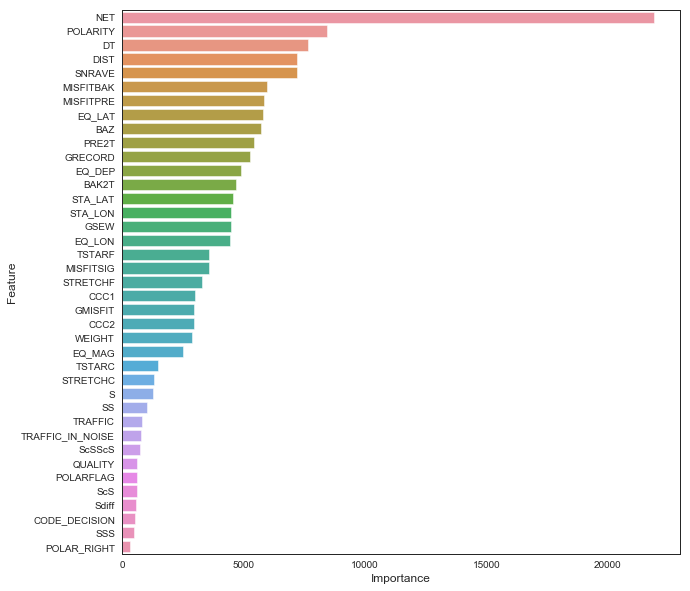

In [378]:
df_feat = feature_importance_df[['Feature','Importance']].groupby('Feature').mean().sort_values(by='Importance',ascending=False).reset_index()
print(df_feat.columns)
plt.figure(figsize=(10,10))
sns.barplot(x='Importance',y='Feature',data=df_feat)

### Use prediction from LightGBM to plot confusion matrix

In [353]:
data2

,NET,DIST,BAZ,STA_LAT,STA_LON,EQ_LAT,EQ_LON,EQ_DEP,EQ_MAG,EQ_NAME,POLARFLAG,QUALITY,CCC1,SNRAVE,DT,STRETCHC,STRETCHF,MISFITSIG,WEIGHT,TSTARF,TSTARC,CCC2,MISFITPRE,MISFITBAK,GRECORD,GSEW,GMISFIT,POLARITY,POLAR_RIGHT,TRAFFIC,PRE2T,BAK2T,TRAFFIC_IN_NOISE,ONE_PERIOD,DECISION,CODE_DECISION,S,SS,SSS,ScS,ScSScS,Sdiff,EQ_LABEL,YEAR
203542,24,74.250,134.301,61.592,-149.131,-4.750,-105.407,10.00,6.1,200708041424,0,3,0.98,2.23,-9.9,0.99,1.08,0.10,0.08,1.70,0.96,0.94,0.30,0.53,28.75,26.5,0.08,-0.18,0,0,0.12,1.04,0,32.4,0.0,1,0,0,0,0,1,0,111,2007
203543,70,114.968,305.401,58.462,26.735,-4.750,-105.407,10.00,6.1,200708041424,0,2,0.96,3.04,-3.7,0.98,1.16,0.12,0.05,0.04,0.94,0.98,0.21,1.26,27.05,26.5,0.02,-0.32,0,0,0.06,0.47,0,30.8,0.0,1,0,0,0,0,1,0,111,2007
203544,242,131.243,73.640,24.847,120.978,-4.750,-105.407,10.00,6.1,200708041424,1,2,0.93,7.16,9.5,0.99,1.28,0.11,0.07,4.12,0.95,0.96,0.03,1.12,30.78,26.5,0.16,0.15,0,0,0.05,0.51,0,34.4,0.0,1,0,0,0,0,1,0,111,2007
203545,262,24.033,184.061,19.332,-103.747,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.84,0.89,-10.7,1.00,0.52,0.05,0.05,0.52,1.00,0.93,0.18,1.36,13.76,26.5,-0.48,-0.19,0,0,0.50,0.33,0,15.4,0.0,0,0,0,0,0,1,0,111,2007
203546,262,24.078,184.379,19.368,-103.615,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.74,0.30,-2.9,1.00,0.35,0.03,0.05,0.36,1.00,0.96,0.14,0.54,9.55,26.5,-0.64,-0.19,0,0,0.28,0.91,0,10.8,0.0,0,0,0,0,0,1,0,111,2007
203547,262,24.098,184.044,19.398,-103.750,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.72,0.60,-7.5,1.00,0.34,0.07,0.05,0.32,1.00,0.95,0.19,0.40,8.74,26.5,-0.67,-0.19,0,0,0.67,0.16,0,10.8,0.0,0,0,0,0,0,1,0,111,2007
203548,262,24.131,184.184,19.427,-103.691,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.62,0.94,23.7,0.97,0.45,0.02,0.05,0.46,1.00,1.00,0.13,1.07,12.46,26.5,-0.53,-0.19,0,0,0.28,0.25,0,14.0,0.0,0,0,0,0,0,1,0,111,2007
203549,262,24.147,184.854,19.423,-103.415,-4.750,-105.407,10.00,6.1,200708041424,0,1,0.87,0.75,2.9,1.00,0.56,0.10,0.00,0.56,1.00,0.86,2.00,1.64,14.84,26.5,-0.44,-0.19,0,0,1.47,0.39,0,17.0,0.0,0,0,0,0,0,1,0,111,2007
203550,262,24.174,184.349,19.466,-103.620,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.69,0.75,4.4,1.00,0.31,0.09,0.05,0.30,1.00,0.85,0.36,1.64,8.20,26.5,-0.69,-0.19,0,0,0.31,0.69,0,9.2,0.0,0,0,0,0,0,1,0,111,2007
203551,262,24.213,184.036,19.514,-103.746,-4.750,-105.407,10.00,6.1,200708041424,0,0,0.85,0.35,-10.2,1.00,0.51,0.04,0.05,0.52,1.00,0.98,0.27,0.69,13.76,26.5,-0.48,-0.19,0,0,0.23,0.60,0,15.4,0.0,0,0,0,0,0,1,0,111,2007


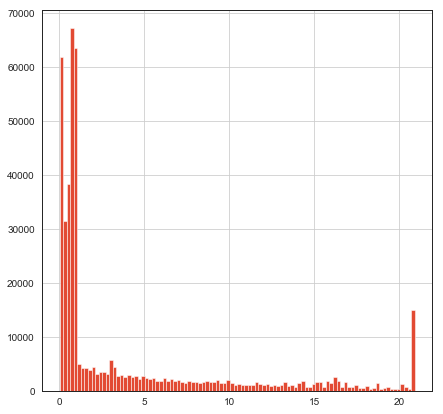

In [355]:
data2.TSTARF.hist(bins=100)

## Conclusion

To directly compare the improvement of performance gain we acquired from the best models, We use the following figure to show the difference:



In [66]:
dfc = meta.MLA.copy()
dfraw = pd.DataFrame([['E.W.',0.498,0.925]],columns=['ModelName','precision','recall'])
dfc = dfc.append(dfraw)
dflgb = pd.DataFrame([['LightGBM',0.87,0.76]],columns=['ModelName','precision','recall'])
dfc = dfc.append(dflgb)
dfc.recall = dfc.recall.astype(float)
dfc.precision = dfc.precision.astype(float)
dfc = dfc.sort_values('precision',ascending=False)
dfc

NameError: name 'meta' is not defined

In [209]:
# fig,ax = plt.subplots(figsize=(10,10))
# dfc.plot(x='precision',y='recall',kind='scatter',ax=ax)
# for k,v in dfc.iterrows():
#     ax.annotate(v.ModelName,( v.precision,v.recall),textcoords='offset points', size=18)
# plt.xlabel('Precision',fontsize=18)
# plt.ylabel('Recall',fontsize=18)

In [127]:
data['EQ_NAME'] = data['EQ_NAME'].astype(str)

In [162]:
# Lets use one event to test 

x_test2 = data.loc[data.EQ_NAME == "200601022213"][all_feat]
x_test2.drop('EQ_NAME',inplace=True,axis=1)
y_test2 = data.loc[data.EQ_NAME == "200601022213"]['DECISION']
# data.EQ_NAME.unique()

final_pred_int = pd.DataFrame(columns=['pred'])
init_value = np.zeros(x_test2.shape[0])
final_pred_int['pred'] = init_value

model_list = [0,1,2,3,4]
for model_num in model_list:
    model = pickle.load(open('./lightgbm_EW.'+str(model_num)+".pkl",'rb'))
    pred = model.predict(x_test2,num_iteration=5000)
    final_pred_int['pred'] += np.array( pred) / len(model_list)

final_pred_int['pred'] = [ int(x/0.5) for x in final_pred_int['pred']]

[[3006  239]
 [  66  826]]
TP is  826
FP is  66
--------> Precision is 0.9260 recall is 0.7756 and F1 is 0.8441 accuracy is 0.9263


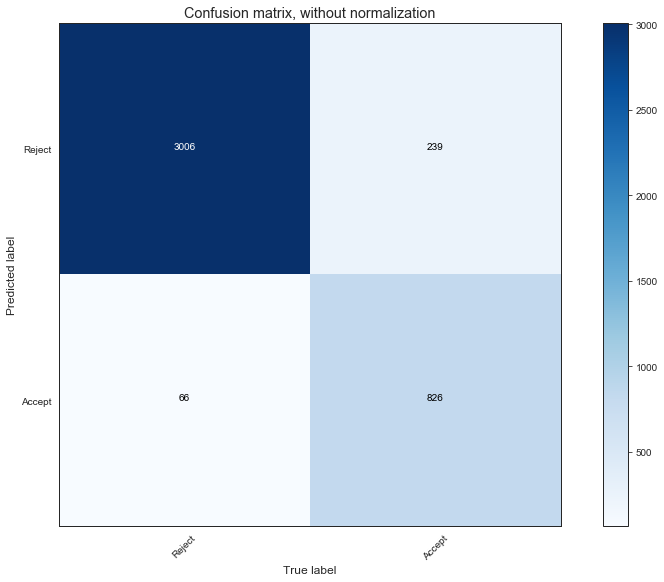

In [163]:
cnf_matrix = metrics.confusion_matrix(final_pred_int.pred.values, y_test2.values)
np.set_printoptions(precision=2)
class_names = ['Reject', 'Accept']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

In [133]:
print(final_pred_int)

      pred
0        1
1        1
2        1
3        0
4        0
5        0
6        1
7        1
8        1
9        1
10       0
11       1
12       0
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
...    ...
4107     0
4108     0
4109     1
4110     1
4111     1
4112     0
4113     0
4114     0
4115     1
4116     1
4117     1
4118     1
4119     1
4120     1
4121     0
4122     1
4123     0
4124     0
4125     0
4126     1
4127     0
4128     0
4129     1
4130     1
4131     0
4132     1
4133     0
4134     0
4135     1
4136     0

[4137 rows x 1 columns]


## Deploy my model


In [210]:
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [437]:
EQ = "201309040023"
event = "/Users/Leviyu/Downloads/"+EQ+"/eventinfo."+EQ+".S.T"
columns = ['STA',
           'NET',
           'DIST',
           'AZ',
           'BAZ',
           'STA_LAT',
           'STA_LON',
           'EQ_LAT',
           'EQ_LON',
           'EQ_DEP',
           'EQ_MAG',
           'EQ_NAME',
           'POLARFLAG',
           'QUALITY',
           'PREM',
           'AMP',
           'CCC1',
           'SNRAVE',
           'DT',
           'PHASE',
           'STRETCHC',
           'STRETCHF',
           'MISFITSIG',
           'COMP',
           'TAG1',
           'TAG2',
           'TAG3',
           'TAG4',
           'TAG5',
           'WEIGHT',
           'TAG6',
           'TAG7',
           'ONSET',
           'ENDSET',
           'TSTARF',
           'TSTARC',
           'CCC2',
           "MISFITPRE",
           'MISFITBAK',
           'GRECORD',
           'GSEW',
           'GMISFIT',
           'POLARITY',
           'POLAR_RIGHT',
           "TRAFFIC",
           'PRE2T',
           'PRE3T',
           'BAK2T',
           'BAK3T',
           'SNR_TROUGH',
           'SNR_PEAK',
           'SNR_SMALL',
           'TRAFFIC_IN_NOISE',
           'ONE_PERIOD',
           "ML_CHOICE",
           "ML_FLAG"
          ]
len(columns)
data = pd.read_csv(event,delimiter=r"\s+",names=columns)
data_orig = data.copy()
data.loc[data.QUALITY<1,'CODE_DECISION'] = 0
data.NET.fillna("NNN",inplace=True)
data.fillna(0,inplace=True)

drop_list = [
"STA",
'PREM',
'AMP',
'TAG1',
'TAG2',
'TAG3',
'TAG4',
'TAG5',
'TAG6',
'TAG7',
'ONSET',
'ENDSET',
'PRE3T',
'BAK3T',
"EQ_NAME_STA_PHASE",
"AZ",
'COMP'
]
for col in drop_list:
    if col in data.columns:
        data = data.drop(col,axis=1)

# drop columns that has only one value
# for col in data.columns:
#     uniquenum = data[col].unique().shape[0]
#     if uniquenum == 1:
#         data = data.drop(col,axis=1)

# Classify different features into numerical and categorial features
numerical_feature = [
'DIST', 'CCC1', 'SNRAVE', 'DT',
'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF',
'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT',
'POLARITY', 'PRE2T', 'BAK2T',
#'ONE_PERIOD',
'EQ_DEP','EQ_MAG',
'STA_LAT','STA_LON','BAZ','EQ_LON','EQ_LAT',
'GSEW','SNR_PEAK'
                    ]
categorial_feature = [
'NET', 
'POLARFLAG', 
'QUALITY',
'POLAR_RIGHT',
'TRAFFIC_IN_NOISE',
'TRAFFIC'
    ]
dummy_feature = [
    'PHASE'
]


print("total feature num is {0} numerical feature num is {1} categorial feature num is {2}".format(
data.shape[1],len(numerical_feature),len(categorial_feature)))

feat_resi = [x for x in data.columns if x not in numerical_feature if x not in categorial_feature
            if x not in dummy_feature]

# all_feat = [x for x in numerical_feature or x in dummy_feature or x in categorial_feature]
# all_feat = numerical_feature + dummy_feature + categorial_feature
# all_feat
# for col in all_feat:
#     if col not in data.columns:
#         all_feat.remove(col)
#         if col in numerical_feature:
#             numerical_feature.remove(col)
#         if col in categorial_feature:
#             categorial_feature.remove(col)

the_phase = data_orig['PHASE'][0]
phase_list = ['S','SS','SSS','ScS','ScSScS','Sdiff']
for iphase in phase_list:
    if the_phase == iphase:
        data[iphase] = 1
    else:
        data[iphase] = 0

# print(all_feat,len(all_feat))
# print(feat_resi)

# For categorial features, we directly label encode them


# label = LabelEncoder()    

# for categorial feature, we use label endocing
for feature in categorial_feature:
    print("--> Work on ", feature)
    encoder = LabelEncoder()
    encoder.classes_ = np.load(feature+".encoder.npy")
    data[feature] = encoder.transform(data[feature])
    
# For dummy variable we use onehotencoding
# new_dummy = []
# for feature in dummy_feature:
#     print("--> work on dummy feature", feature)
    
    
#     ff = pd.get_dummies(data[feature])
#     for f in ff.columns:
#         new_dummy.append(f)
#     data = pd.concat([data,ff],axis=1)
#     data.drop(feature,inplace=True,axis=1)

# print("new dummy features are ", new_dummy)


# Remove outlier
feat = 'SNRAVE'
value = 30
data.loc[data[feat]>value,feat] = value

feat = 'MISFITSIG'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'MISFITPRE'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'MISFITBAK'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'GMISFIT'
value = 50
data.loc[data[feat]>value,feat] = value


feat = 'PRE2T'
value = 10
data.loc[data[feat]>value,feat] = value

feat = 'BAK2T'
value = 10
data.loc[data[feat]>value,feat] = value

for col in ['ML_CHOICE',"ML_FLAG",'SNR_SMALL','SNR_PEAK','SNR_TROUGH','EQ_NAME','PHASE']:
    if col in data.columns:
        data.drop(col,axis=1,inplace=True)
        
# predictions = np.zeros(len(data))
model_list = [0,1]
# for num in model_list:
#     model = pickle.load(open("./lightgbm_EW."+str(num)+".pkl",'rb'))
#     pred = model.predict(data,num_iteration=1000)
predictions = meta.make_new_prediction(data)
#     print(np.max(pred))
#     print(np.max(pred))
#     predictions += pred / len(model_list)
print(sum(predictions))
print(sum(predictions) / len(predictions))

total feature num is 41 numerical feature num is 28 categorial feature num is 6
--> Work on  NET
--> Work on  POLARFLAG
--> Work on  QUALITY
--> Work on  POLAR_RIGHT
--> Work on  TRAFFIC_IN_NOISE
--> Work on  TRAFFIC
---> make new prediction on  RandomForest
0
0.0


In [405]:
# # # sum(predictions)
# # # predictions
# data_orig['ML_CHOICE'] = predictions # [int(x/0.5) for x in predictions ]
# data_orig['ML_FLAG'] = 0
# data_orig.loc[((data_orig['QUALITY']>=1) & (data_orig.ML_CHOICE == 0)),'ML_FLAG'] = 1
# data_orig[['STA','QUALITY','ML_CHOICE']]


In [72]:
# predictions

In [73]:
# predictions = np.zeros(len(x_test))
# model_list = [0,1]
# for num in model_list:
#     model = pickle.load(open("./lightgbm_EW."+str(num)+".pkl",'rb'))
#     pred = model.predict(x_test,num_iteration=3000)
# #     print(np.max(pred))
#     print(np.max(pred))
#     predictions += pred / len(model_list)

In [166]:
data[all_feat]

,DIST,CCC1,SNRAVE,DT,STRETCHC,STRETCHF,MISFITSIG,WEIGHT,TSTARF,TSTARC,...,TRAFFIC_IN_NOISE,TRAFFIC,CODE_DECISION,S,SS,SSS,ScS,ScSScS,Sdiff,EQ_NAME
0,23.276,0.96,3.12,3.3,1.00,1.27,0.02,0.48,4.34,0.97,...,0,0,1,0,0,0,0,1,0,199401101553
1,24.597,0.88,4.08,1.0,1.00,1.74,0.03,0.64,11.55,0.95,...,0,0,1,0,0,0,0,1,0,199401101553
2,67.274,0.96,2.22,3.5,1.00,1.23,0.02,0.11,3.49,0.97,...,0,0,1,0,0,0,0,1,0,199401101553
3,67.368,0.98,2.90,4.0,1.00,1.12,0.10,0.08,1.42,0.97,...,0,0,1,0,0,0,0,1,0,199401101553
4,68.686,0.98,2.31,5.6,1.00,1.06,0.03,0.53,0.95,0.98,...,0,0,1,0,0,0,0,1,0,199401101553
5,69.863,0.98,3.03,4.0,1.00,1.07,0.04,0.67,0.87,0.97,...,0,0,1,0,0,0,0,1,0,199401101553
6,71.015,0.97,2.62,3.3,0.99,1.11,0.11,0.05,1.48,0.96,...,0,0,1,0,0,0,0,1,0,199401101553
7,23.142,0.88,3.57,2.4,1.00,1.65,0.12,0.08,10.02,0.95,...,0,0,0,0,0,0,0,1,0,199401101553
8,23.811,0.81,3.35,1.8,0.99,1.91,0.14,0.09,13.83,0.94,...,0,0,0,0,0,0,0,1,0,199401101553
9,24.640,0.93,1.12,3.4,1.00,1.41,0.02,0.05,6.57,0.96,...,0,0,0,0,0,0,0,1,0,199401101553


In [380]:
data2.shape

(324570, 44)

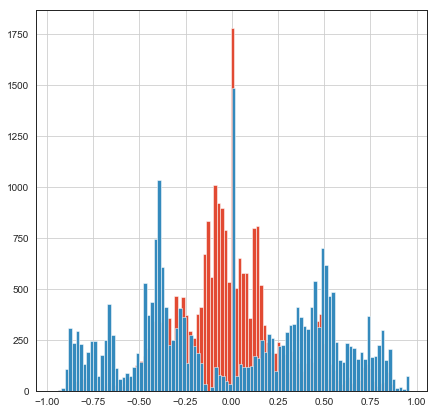

In [390]:
plt.figure()
data2.loc[(data2.DECISION!=1) & data2.S==1]['POLARITY'].hist(bins=100)

data2.loc[(data2.DECISION==1) & data2.S==1]['POLARITY'].hist(bins=100)